# Hypothesis and inference

For our purposes, hypotheses are assertions like “this coin is fair” or “data scien‐
tists prefer Python to R” or “people are more likely to navigate away from the page
without ever reading the content if we pop up an irritating interstitial advertisement
with a tiny, hard-to-find close button” that can be translated into statistics about data.
Under various assumptions, those statistics can be thought of as observations of ran‐
dom variables from known distributions, which allows us to make statements about
how likely those assumptions are to hold.

## Hypothesis test

in a classical setup, we have a null hypothesis, H0, that represents some default posi‐
tion, and some alternative hypothesis, H1, that we’d like to compare it with. We use
statistics to decide whether we can reject H0 as false or not.

### Test if a coin flip is fair

In [1]:
from typing import Tuple
import math

def normal_approximation_to_binomial(n:int,p: float) -> Tuple[float, float]:
    """ Returns mu and sigma corresponding to a Binomial(n, p)"""
    mu = p * n
    sigma = math.sqrt(p * (1 - p) * n)
    return mu, sigma

P(both | older): 0.5007089325501317
P(both | either): 0.3311897106109325


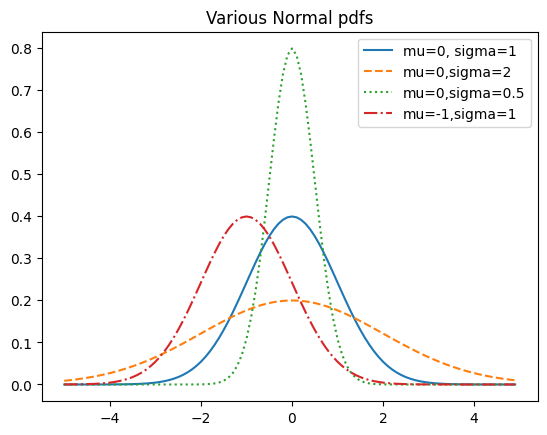

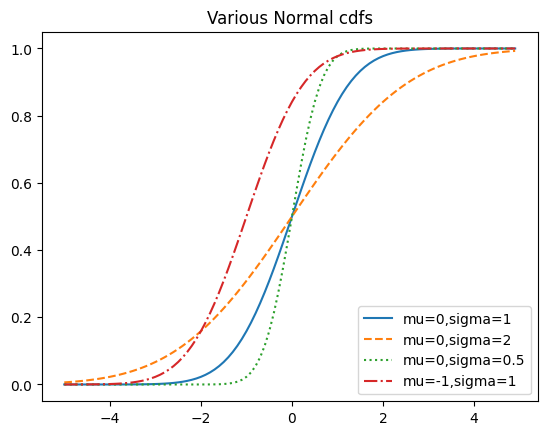

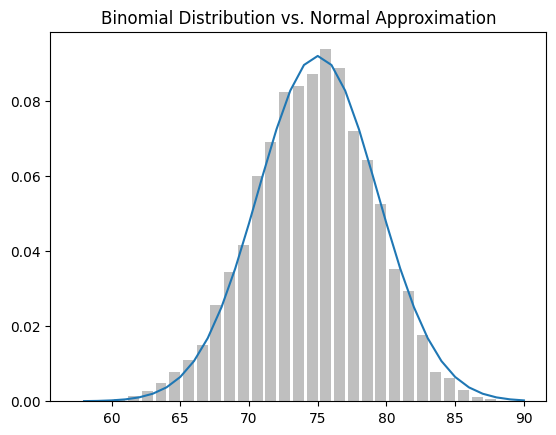

In [2]:
from modules.probability import normal_cdf

# The normal cdf is the probability the variable is below a threshold
normal_probability_below = normal_cdf

# its above if its not below threshold
def normal_probability_above(lo: float = 0, mu: float = 0, sigma: float = 1) -> float:
    """The probability that an  N(mu, sigma) is greater then lo"""
    return 1 - normal_cdf(lo, mu, sigma)

# its beetween if its less then hi, but higher than lo
def normal_probability_beetween(lo: float, hi: float, mu: float = 0, sigma: float =1) -> float:
    """The probability that N(mu, sigma) is beetween hi and lo"""
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma) 

def normal_probability_outside(lo:float, hi:float, mu: float = 0,sigma: float = 1) -> float:
    """The probability  that N(mu, sigma) is not beetween hi and lo"""
    return 1 - normal_probability_beetween(lo, hi, mu, sigma)

We can also do the reverse —

find either the nontail region or the (symmetric) interval
around the mean that accounts for a certain level of likelihood. For example, if we
want to find an interval centered at the mean and containing 60% probability, then we find the cutoffs where the upper and lower tails each contain 20% of the probabil‐
ity (leaving 60%)

In [3]:
from typing import Tuple
from modules.probability import inverse_normal_cdf

def normal_upper_bound(probability: float,
mu: float = 0,
sigma: float = 1) -> float:
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float,
mu: float = 0,
sigma: float = 1) -> float:
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float,
mu: float = 0,
sigma: float = 1) -> Tuple[float, float]:
    """
    Returns the symmetric (about the mean) bounds
    that contain the specified probability
    """
    tail_probability = (1 - probability) / 2
    # upper bound should have tail_probability above it
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    # lower bound should have tail_probability below it
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    return lower_bound, upper_bound

Let’s say that we choose to flip the coin n = 1,000 times. If our hypothesis
of fairness is true, X should be distributed approximately normally with mean 500
and standard deviation 15.8:

In [4]:
mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

mu_0, sigma_0

(500.0, 15.811388300841896)

#### Significance

For reasons lost to
the annals of history, this willingness is often set at 5% or 1%. Let’s choose 5%.

In [7]:
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)

Consider the test that rejects H0 if X falls outside the bounds given by

In [8]:
lower_bound, upper_bound

(469.01026640487555, 530.9897335951244)

Assuming p really equals 0.5 (i.e., H0 is true), there is just a 5% chance we observe an
X that lies outside this interval, which is the exact significance we wanted. 

Said differently, if H0 is true, then, approximately 19 times out of 20, this test will give the cor‐
rect result.

#### power

he probability of not
making a type 2 error (“false negative”), in which we fail to reject H0 even though it’s
false.

 In order to measure this, we have to specify what exactly H0 being false means.
(Knowing merely that p is not 0.5 doesn’t give us a ton of information about the dis‐
tribution of X.) In particular, let’s check what happens if p is really 0.55, so that the
coin is slightly biased toward heads.

In [10]:
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

lo, hi

(469.01026640487555, 530.9897335951244)

In [14]:
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

type_2_probability = normal_probability_beetween(lo,hi, mu_1, sigma_1)

power = 1 - type_2_probability

power

0.886548001295367

Imagine instead that our null hypothesis was that the coin is not biased toward heads,
or that p ≤ 0 . 5. In that case we want a one-sided test that rejects the null hypothesis
when X is much larger than 500 but not when X is smaller than 500. So, a 5% signifi‐
cance test involves using normal_probability_below to find the cutoff below which
95% of the probability lies:

In [18]:
hi = normal_upper_bound(0.95, mu_0, sigma_0)

type_2_probability =  normal_probability_below(hi, mu_1, sigma_1)

power = 1 - type_2_probability

power

0.9363794803307173

### p-values

Instead of
choosing bounds based on some probability cutoff, we compute the probability—
assuming H0 is true—that we would see a value at least as extreme as the one we
actually observed

For our two-sided test of whether the coin is fair, we compute:

In [19]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
    """How likely are we to see a value at least as extreme as x 
    (in either direction) if our values are from an N(mu, sigma)"""
    if x >= mu:
        # x is greater than the mean, so the tail is everything greater than x
        return  2 * normal_probability_above(x, mu, sigma)
    else:
        # x is less than the mean, so the tail is everything less than x
        return  2 * normal_probability_below(x, mu, sigma)

In [20]:
two_sided_p_value(529.5, mu_0, sigma_0)

0.06207721579598835

Since the p-value is greater than our 5% significance, we don’t reject the null. 

### Confidence intervals

we can estimate the probability of the unfair coin by looking at the average value of the Bernoulli variables corresponding to each flip—1 if heads, 0 if tails. 

If we observe 525 heads out of 1,000 flips, then we estimate p equals 0.525.

Here we don’t know p, so instead we use our estimate:

In [27]:
p_hat = 525 / 1000
mu = p_hat
sigma = math.sqrt(p_hat * (1 - p_hat) /1000)

mu, sigma

(0.525, 0.015791611697353755)

In [29]:
normal_two_sided_bounds(0.95, mu, sigma)

(0.4940490278129096, 0.5559509721870904)

This is a statement about the interval, not about p. You should
understand it as the assertion that if you were to repeat the experiment many times, 95% of the time the “true” parameter (which is
the same every time) would lie within the observed confidence
interval (which might be different every time)

In particular, we do not conclude that the coin is unfair, since 0.5 falls within our confidence interval

If you’re setting out to find “significant” results, you usually
can. Test enough hypotheses against your dataset, and one of them will almost certainly appear significant. Remove the right outliers, and you can probably get your p-
value below 0.05.

If you want to do good science, you should determine your hypotheses before looking
at the data, you should clean your data without the hypotheses in mind, and you
should keep in mind that p-values are not substitutes for common sense.

### A/B testing

In [35]:
def estimated_parameters(N: int, n:int) -> Tuple[float, float]:
    p = n/N
    sigma = math.sqrt(p * (1 - p) /N)
    return p, sigma

In [43]:
def a_b__test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
    p_A, sigma_A = estimated_parameters(N_A, n_A)
    p_B, sigma_B = estimated_parameters(N_B, n_B)
    return (p_B -  p_A) / math.sqrt(sigma_A ** 2 + sigma_B ** 2)

In [46]:
# For example, if “tastes great” gets 200 clicks out of 1,000 views and “less bias” gets 180
# clicks out of 1,000 views, the statistic equals

z = a_b__test_statistic(1000, 200, 1000, 180)
z

# The probability of seeing such a large difference if the means were actually equal would be:

two_sided_p_value(z)

0.2541419765422359